In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
from jax import jit,grad,hessian,jacfwd,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from jax.scipy.linalg import block_diag
from jax.scipy.linalg import solve
from scipy.interpolate import RectBivariateSpline
from pde_solvers.BurgerSolver import get_burger_solver
from EquationModel import InducedRKHS

import numpy as np
from scipy.sparse import diags_array
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from scipy.sparse.linalg import spsolve
from tqdm.auto import tqdm
from scipy.sparse import identity
from scipy.sparse import eye_array


In [2]:
def heat_step(k,kappa_func,n):
    h = 1/(n+1)
    xgrid = np.linspace(0,1,n+2)
    kappa = kappa_func(xgrid[1:-1]).reshape(-1,1)
    L = diags_array([np.ones(n-1),-2 * np.ones(n),np.ones(n-1)],offsets = [-1,0,1])/(h**2)
    L = kappa * L
    B = L * k
    I = eye_array(n)
    L1 = I - B/4
    R1 = I + B/4
    L2 = I - B/3
    def trbdf2_heat(u):
        u1 = spsolve(L1,R1@u)
        return spsolve(L2,(1/3) * (4 * u1 - u))
    return trbdf2_heat

def get_inhomogeneous_heat_solver(kappa_func,k = 1e-4,n = 1000):
    xgrid = np.linspace(0,1,n+2)
    stepper = heat_step(k,kappa_func,n)
    
    def solve_heat(u0,final_t = 1.):
        num_timesteps = final_t//k
        u_vals = [u0]
        u = u0
        for i in tqdm(range(int(num_timesteps))):
            u = stepper(u)
            u_vals+=[u]
        return np.array(u_vals),np.arange(0,final_t,k)
    return xgrid,solve_heat

In [3]:
k = 5e-4

kappa_func = lambda x:0.25*(0.01 + x**2)
alpha = 0.5
def func_u0(x):
    u0 = np.sin(np.pi*x)
    return u0

grid,solver = get_inhomogeneous_heat_solver(kappa_func,k,n = 1999)

u0 = func_u0(grid)[1:-1]

sols,tvals = solver(u0,1.01)
sols = np.hstack([np.zeros((len(sols),1)),sols,np.zeros((len(sols),1))])

  0%|          | 0/2019 [00:00<?, ?it/s]

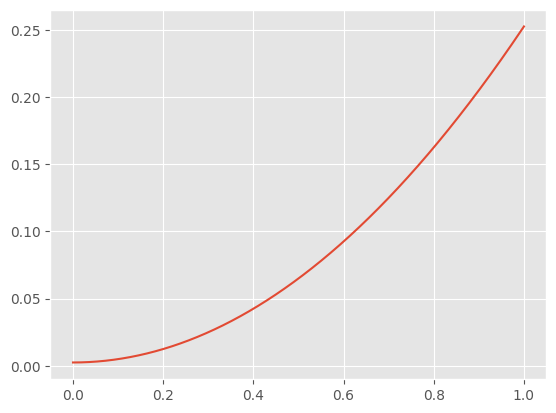

In [4]:
plt.plot(grid,kappa_func(grid))

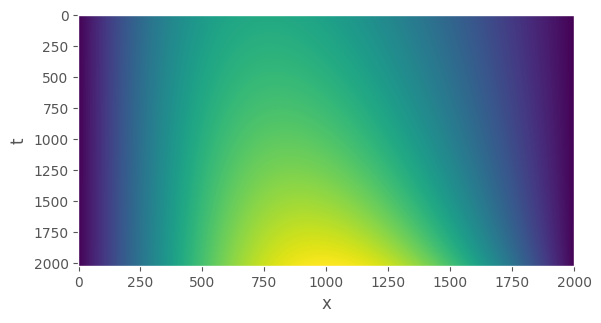

In [5]:
plt.imshow(sols[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)

In [6]:
interp = RectBivariateSpline(tvals,grid,sols)
def u_true_function(x):
    return interp(x[:,0],x[:,1],grid = False)

def ut_true_function(x):
    ut_interp = interp.partial_derivative(1,0)
    return ut_interp(x[:,0],x[:,1],grid = False)

In [7]:
def build_tx_grid(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    full_x_grid = jnp.linspace(x_range[0],x_range[1],num_grid_x)
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary

def build_tx_grid_chebyshev(t_range,x_range,num_grid_t,num_grid_x):
    full_t_grid = jnp.linspace(t_range[0],t_range[1],num_grid_t)
    nodes = jnp.cos(jnp.pi*(2*jnp.arange(0,num_grid_x,1)[::-1])/(2*(num_grid_x-1)))
    reg_grid = jnp.linspace(-1,1,num_grid_x)
    alpha = 0.6
    nodes = alpha * nodes + (1-alpha) * reg_grid
    # nodes = jnp.sign(nodes)*jnp.abs(nodes)**(5/4)
    full_x_grid = (nodes  + (x_range[0]+1))/(2*(x_range[1]-x_range[0]))
    x_interior = full_x_grid[1:-1]
    x_boundary = full_x_grid[jnp.array([0,-1])]

    #Get interior points
    t,x = jnp.meshgrid(full_t_grid,x_interior)
    tx_interior = jnp.vstack([t.flatten(),x.flatten()]).T

    #I'm doing this with meshgrid to handle more general higher dimensions, ie circular domain in 2d
    #Get boundary points
    t,x = jnp.meshgrid(full_t_grid,x_boundary)
    tx_boundary = jnp.vstack([t.flatten(),x.flatten()]).T
    return tx_interior,tx_boundary


In [8]:
num_grid_x = 26
num_grid_t = 26

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_bdy,tx_int])

init_obs_inds = jnp.where(tx_int[:,0]==0)[0][::1]
num_init_obs_inds = len(init_obs_inds)


u_true = u_true_function(tx_all)

num_obs = 40
np.random.seed(40)

remaining_inds = list(
    set(list(np.arange(len(tx_int)))) - 
    set(list(np.where(tx_int[:,0]==0)[0]))
)

x_t_sample_inds = np.random.choice(remaining_inds,num_obs,replace = False)
x_t_sample_inds = jnp.hstack([init_obs_inds,x_t_sample_inds])

tx_obs = jnp.vstack([tx_bdy,tx_int[x_t_sample_inds]])

u_obs = u_true_function(tx_obs)


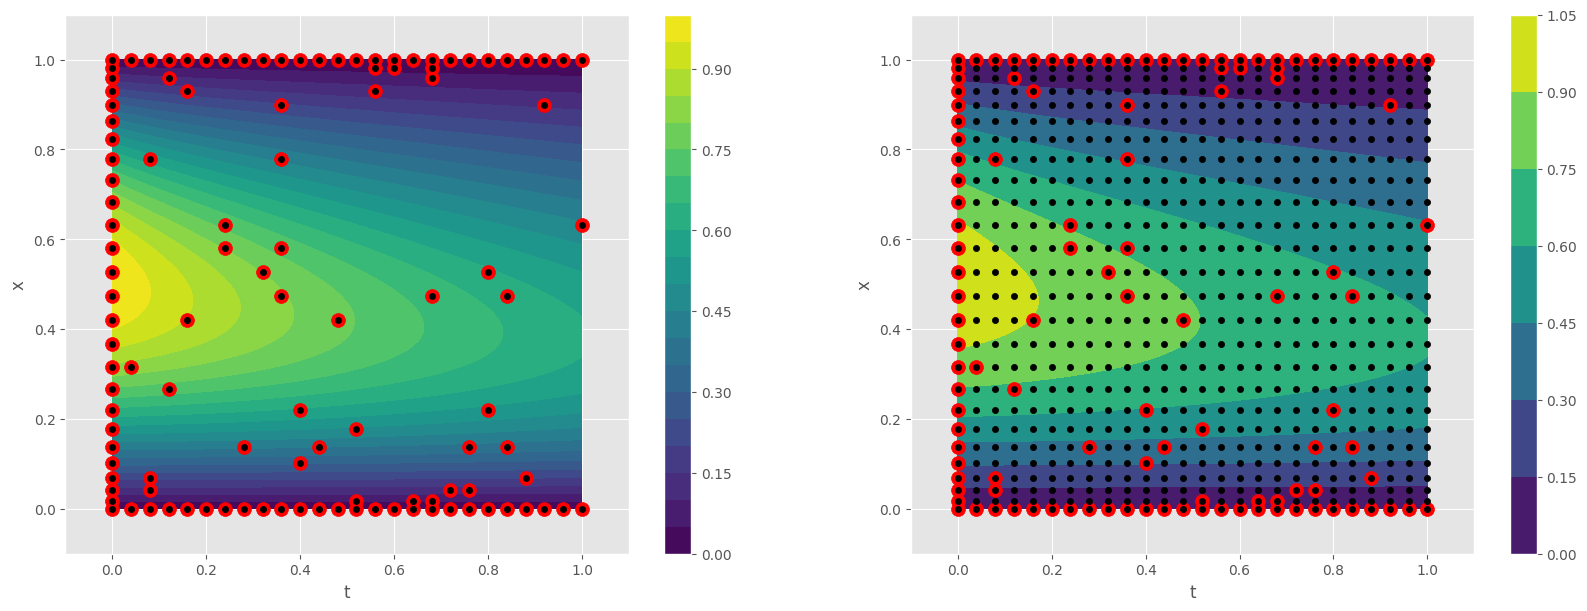

In [9]:
num_fine_grid = 100
final_time = 1
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.subplot(1,2,2)
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine))
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)

plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 20)


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

Text(0.5, 1.0, 'Input Data')

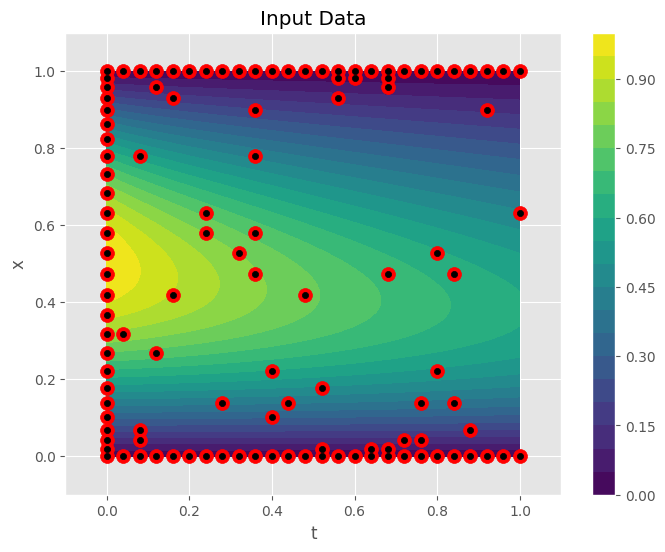

In [10]:
plt.figure(figsize=(8,6))
plt.tricontourf(tx_fine[:,0],tx_fine[:,1],u_true_function(tx_fine),20)
plt.colorbar()

plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red', s = 100)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 20)
plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Input Data")

In [11]:
# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,500),jnp.linspace(0,1,500))
# samples = np.random.multivariate_normal(jnp.zeros(len(Kt)),Kt,10)
# plt.figure(figsize=(24,5))
# for s in samples[:2]:
#     plt.plot(jnp.linspace(0,1,500),s)

# Kt = get_kernel_block_ops(get_gaussianRBF(0.001),[eval_k],[eval_k])(jnp.linspace(0,1,26),jnp.linspace(0,1,500))
# plt.figure(figsize=(20,5))
# for krow in Kt:
#     plt.plot(krow)

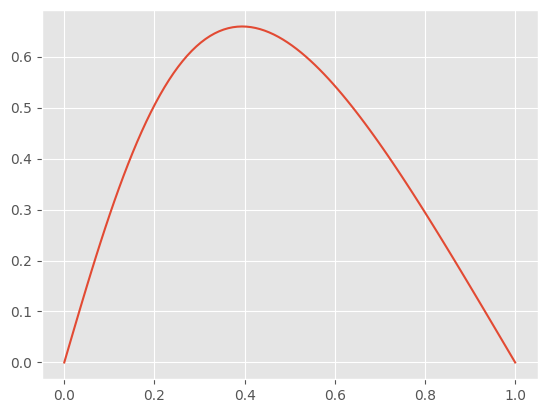

In [12]:
grid_points = jnp.linspace(0,1,100)
plot_views = jnp.vstack([0.8*jnp.ones(100),grid_points]).T

plt.plot(grid_points,u_true_function(plot_views))

In [13]:
jnp.sqrt(0.025)

Array(0.15811388, dtype=float64, weak_type=True)

In [14]:
from Kernels import get_gaussianRBF,get_centered_scaled_poly_kernel,get_sum_of_kernels,get_matern
from EquationModel import CholInducedRKHS

u_operators = tuple([eval_k,dx_k,dt_k])
feature_operators = tuple([eval_k,dx_k,dxx_k])


#k_u = get_sum_of_kernels([get_gaussianRBF(0.1),get_gaussianRBF(0.15)],coefficients=[0.5,0.5])#get_gaussianRBF(0.1)
k_u = get_matern(6,0.2)
u_model = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(1,grid_features_init,c=1.,scaling = 'diagonal')
k_P_x_part = get_gaussianRBF(0.25)

def k_P(x,y):
    return k_P_u_part(x[2:],y[2:]) * k_P_x_part(x[1:2],y[1:2])
class P_model():
    kernel_function = jit(
        get_kernel_block_ops(k_P,[eval_k],[eval_k])
    )
    num_params = len(grid_features_init)

    @jit
    def predict(input_data,params):
        K = P_model.kernel_function(input_data,input_data)
        return K@params
    
from EquationModel import OperatorPDEModel

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

2024-06-30 19:16:50.361680: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %reduce.1208 = f64[676,676]{1,0} reduce(f64[676,676,2]{2,1,0} %broadcast.290, f64[] %constant.14), dimensions={2}, to_apply=%region_32.1204, metadata={op_name="jit(k_super)/jit(main)/reduce_sum[axes=(2,)]" source_file="/mnt/share/homes/owlx/alexhsu/keql/keql_tools/Kernels.py" source_line=103}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-30 19:16:50.685239: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.323684727s
Constant folding an instruction is taking > 1s:

  %red

In [15]:
# init_feats = EqnModel.get_stacked_eqn_features((u_params_init,))
# KP_init = P_model.kernel_function(init_feats,init_feats)
# P_params_init = solve(KP_init+1e-4 * diagpart(KP_init),EqnModel.get_overall_rhs(u_params_init))

In [16]:
import LM_Solve
import importlib
importlib.reload(LM_Solve)
from LM_Solve import LevenbergMarquadtMinimize
from LM_Solve import adaptive_refine_solution

params_init = jnp.hstack([u_params_init,jnp.zeros(P_model.num_params)])

params,loss_vals,JtRes,improvement_ratios,alpha_vals,iterate_history = LevenbergMarquadtMinimize(
    params_init.copy(),
    EqnModel,
    beta = 1e-10,
    max_iter = 250,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100,
)
p_adjusted,refinement_losses,reg_vals = adaptive_refine_solution(params,EqnModel,5*alpha_vals[-1],200)

stacked_loss_vals = jnp.hstack([jnp.array(loss_vals),jnp.array(refinement_losses)])

  0%|          | 0/250 [00:00<?, ?it/s]

Iteration 0, loss = 0.00377, Jres = 7.547, alpha = 0.08333, improvement_ratio = 1.001
Iteration 1, loss = 0.00135, Jres = 0.7228, alpha = 0.06944, improvement_ratio = 0.9944
Iteration 2, loss = 0.0007637, Jres = 0.2299, alpha = 0.05787, improvement_ratio = 1.005
Iteration 3, loss = 0.0004982, Jres = 0.07386, alpha = 0.04823, improvement_ratio = 1.004
Iteration 4, loss = 0.0003478, Jres = 0.02919, alpha = 0.04019, improvement_ratio = 1.001
Iteration 5, loss = 0.0002548, Jres = 0.01581, alpha = 0.03349, improvement_ratio = 0.9991
Iteration 100, loss = 1.516e-08, Jres = 0.0006029, alpha = 1.775e-06, improvement_ratio = 0.7038
Iteration 200, loss = 4.784e-09, Jres = 2.779e-05, alpha = 8.333e-07, improvement_ratio = 0.9933


  0%|          | 0/200 [00:00<?, ?it/s]

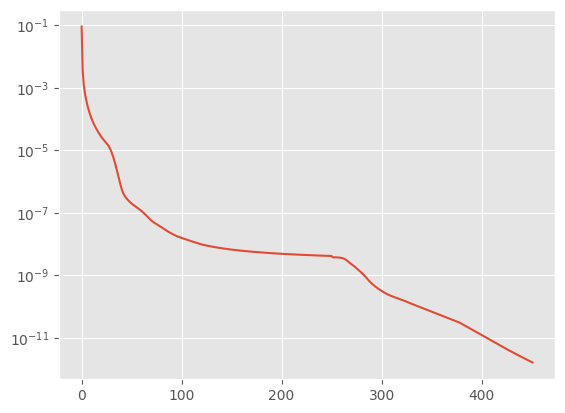

In [17]:
plt.plot(stacked_loss_vals)
plt.yscale('log')

In [18]:
hess_loss = jit(jax.hessian(EqnModel.loss))
gradloss = jit(jax.grad(EqnModel.loss))

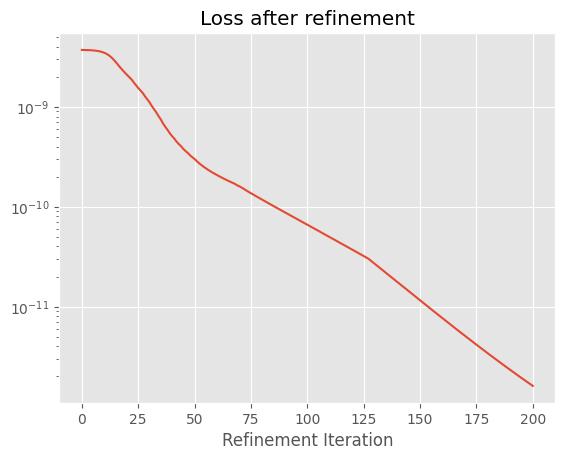

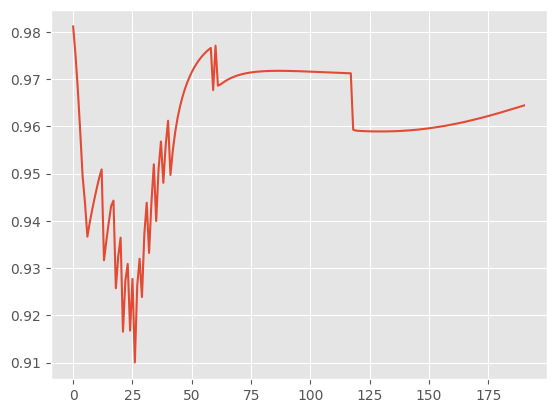

In [19]:
plt.plot(refinement_losses)
plt.xlabel("Refinement Iteration")
plt.title("Loss after refinement")
plt.yscale('log')
plt.show()
plt.plot(refinement_losses[10:]/refinement_losses[9:-1])

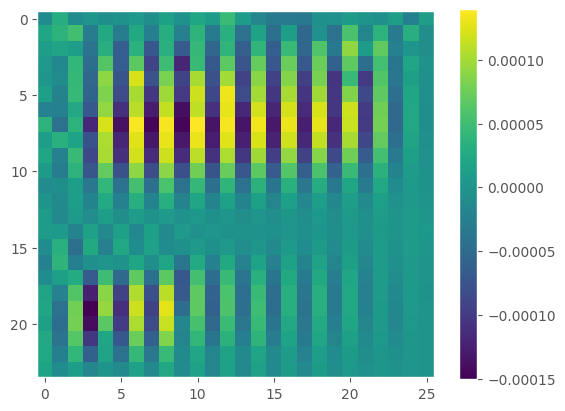

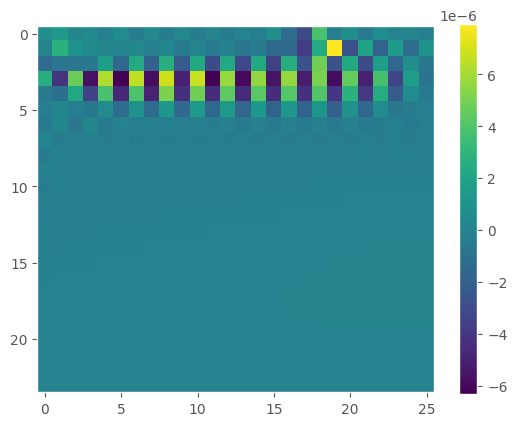

Pre Refinement  3.486574121037922e-09
Post Refinement  2.2750502343368906e-12


In [20]:
equation_residuals = EqnModel.equation_residual(params)
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()
print("Pre Refinement ",jnp.mean(equation_residuals**2))
print("Post Refinement ",jnp.mean(equation_residuals_refined**2))

In [141]:
# analyze_hessian(hess_loss(p_adjusted),gradloss(p_adjusted))

In [21]:
# u_sol = params[:u_model.num_params]
# P_sol = params[u_model.num_params:]

# u_sol = p_adjusted[:u_model.num_params]
# P_sol = p_adjusted[u_model.num_params:]

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]

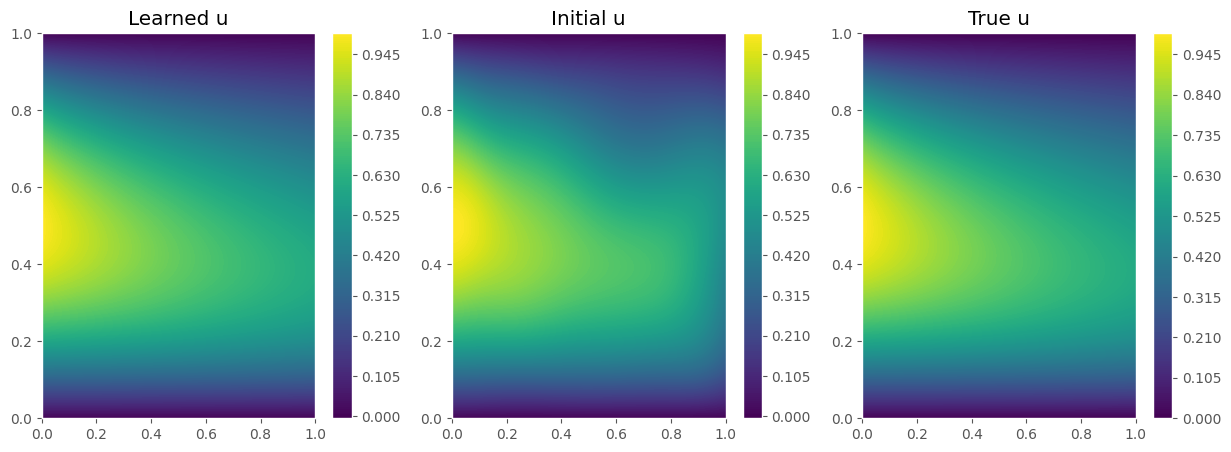

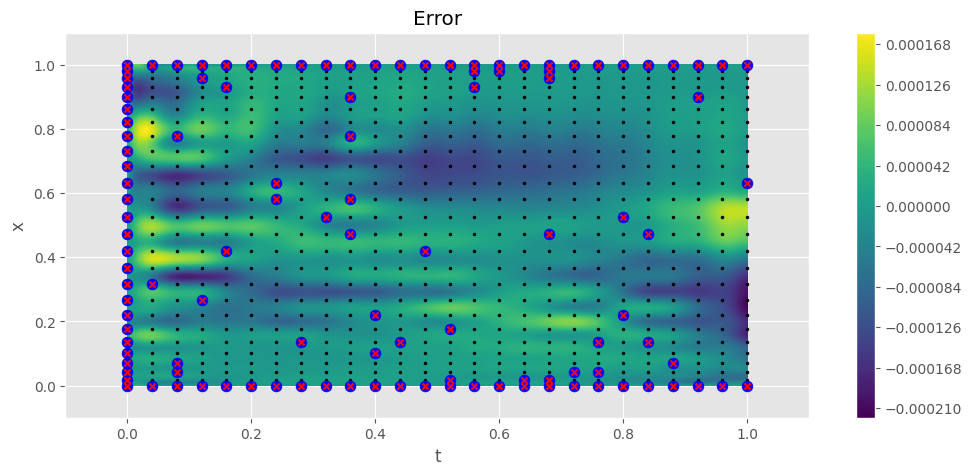

In [22]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)

u_true_fine = u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.title("Learned u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_eval_fine,200)
plt.colorbar()
plt.subplot(1,3,2)
plt.title("Initial u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_model.point_evaluate(tx_grid_fine,u_params_init),200)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine,200)
plt.colorbar()

plt.show()
plt.figure(figsize = (12,5))
plt.title("Error")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],u_true_fine-u_eval_fine,250)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='blue',s = 60)
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 20,marker = 'x')


plt.xlabel("t")
plt.ylabel("x")
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.show()

In [23]:
def compare_values(x,y):
    plt.scatter(x,y,alpha = 0.6)
    plt.plot([np.min(x),np.max(x)],
            [np.min(x),np.max(x)],c = 'blue')


In [25]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interp.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interp.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interp.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = solve(K+1e-5*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = u_model.evaluate_operators(feature_operators,tx_fine_int,u_params_init).reshape(len(tx_fine_int),len(feature_operators),order = 'F')
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

2024-06-30 19:19:17.226547: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 2s:

  %reduce.32 = f64[10000,676]{1,0} reduce(f64[10000,676,2]{2,1,0} %broadcast.1053, f64[] %constant.65), dimensions={2}, to_apply=%region_32.350, metadata={op_name="jit(get_single_eqn_features)/jit(main)/jit(evaluate_operators)/reduce_sum[axes=(2,)]" source_file="/mnt/share/homes/owlx/alexhsu/keql/keql_tools/Kernels.py" source_line=103}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2024-06-30 19:19:35.018393: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 19.791944254s
Constant fol

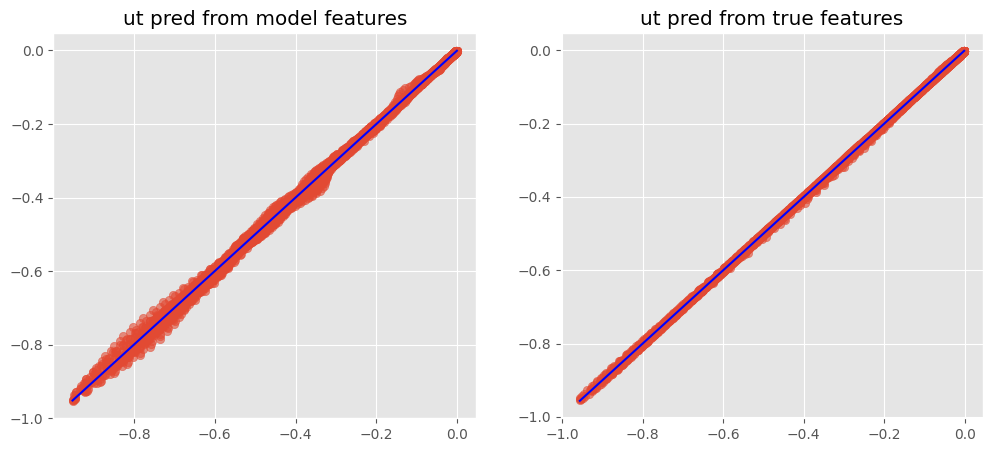

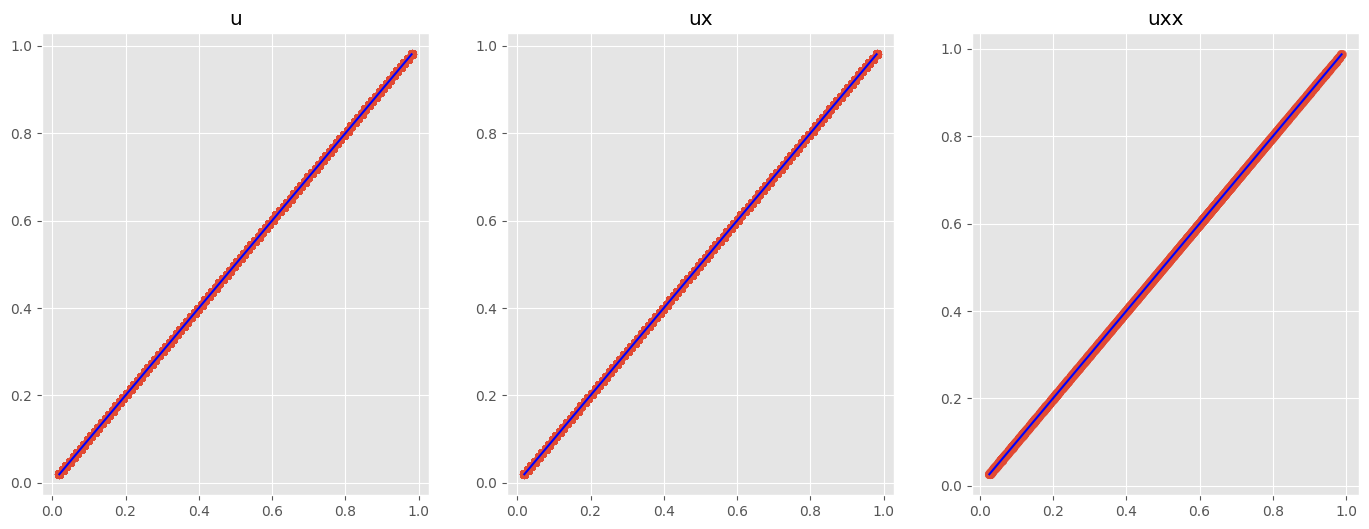

In [26]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,0],true_features[:,0])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,1],true_features[:,1])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,2],true_features[:,2])
plt.show()


In [27]:
def get_nrmse(true,pred):
    return jnp.sqrt(jnp.mean((true-pred)**2)/jnp.mean(true**2))

def get_clipped_nrmse(true,pred, perc = 1):
    pred_clipped = jnp.clip(pred,jnp.percentile(pred,perc),jnp.percentile(pred,100-perc))
    true_clipped = jnp.clip(true,jnp.percentile(true,perc),jnp.percentile(true,100-perc))
    return get_nrmse(true_clipped,pred_clipped)


def get_nmae(true,pred):
    return jnp.mean(jnp.abs(true-pred))/jnp.mean(jnp.abs(true))

print("Normalized RMSE")
print("Optimized model feature predictions ",get_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nrmse(ut_true,P_preds_init_model_features_init))

print("Clipped Normalized RMSE")
print("Optimized model feature predictions ",get_clipped_nrmse(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_clipped_nrmse(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_clipped_nrmse(ut_true,P_preds_init_model_features_init))


print("Normalized MAE")
print("Optimized model feature predictions ",get_nmae(ut_true,preds_ut_model_features))
print("Optimized true feature predictions ",get_nmae(ut_true,preds_ut_true_features))
print("2 step model feature predictions ",get_nmae(ut_true,P_preds_init_model_features))
print("2 step true feature predictions ",get_nmae(ut_true,P_preds_init_true_features))
print("2 step init model feature predictions ",get_nmae(ut_true,P_preds_init_model_features_init))

Normalized RMSE
Optimized model feature predictions  0.0193559457342326
Optimized true feature predictions  0.005439383265782215
2 step model feature predictions  0.4072382138732592
2 step true feature predictions  0.4076132644010033
2 step init model feature predictions  175.05625536697409
Clipped Normalized RMSE
Optimized model feature predictions  0.018605711080553262
Optimized true feature predictions  0.0051833681400159735
2 step model feature predictions  0.4066039378749567
2 step true feature predictions  0.40668472746682754
2 step init model feature predictions  170.4411663732092
Normalized MAE
Optimized model feature predictions  0.012639786366427553
Optimized true feature predictions  0.004085447667806763
2 step model feature predictions  0.3428838724601375
2 step true feature predictions  0.34263120039002953
2 step init model feature predictions  91.38787611121981


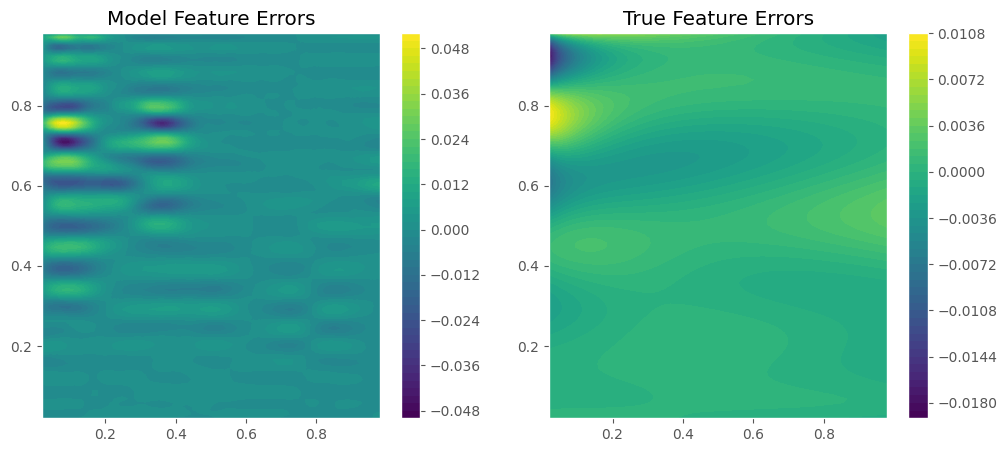

In [28]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Model Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,50,)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True Feature Errors")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_true_features,50,)
plt.colorbar()

plt.show()

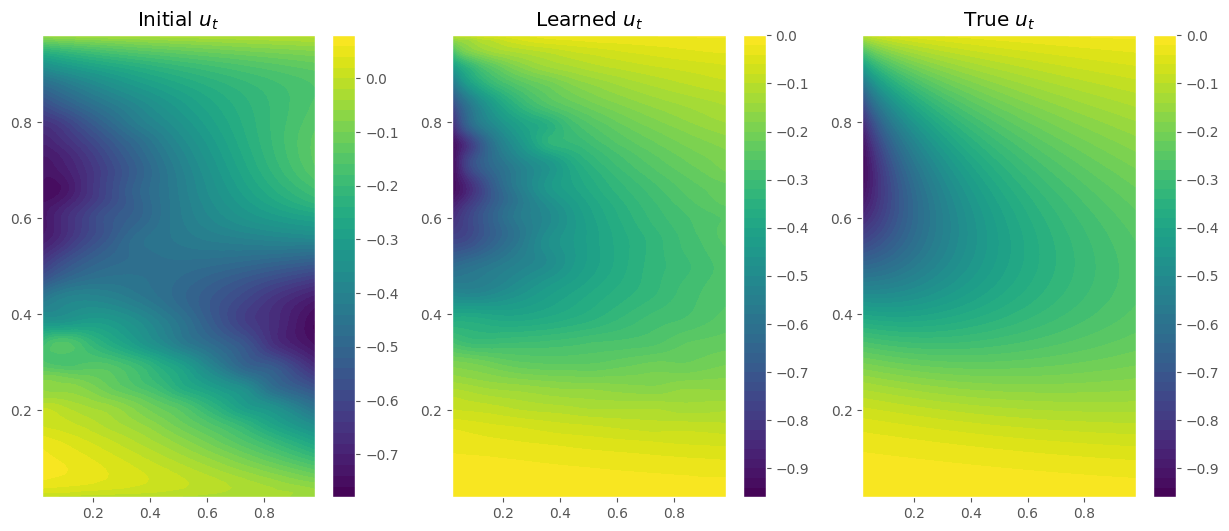

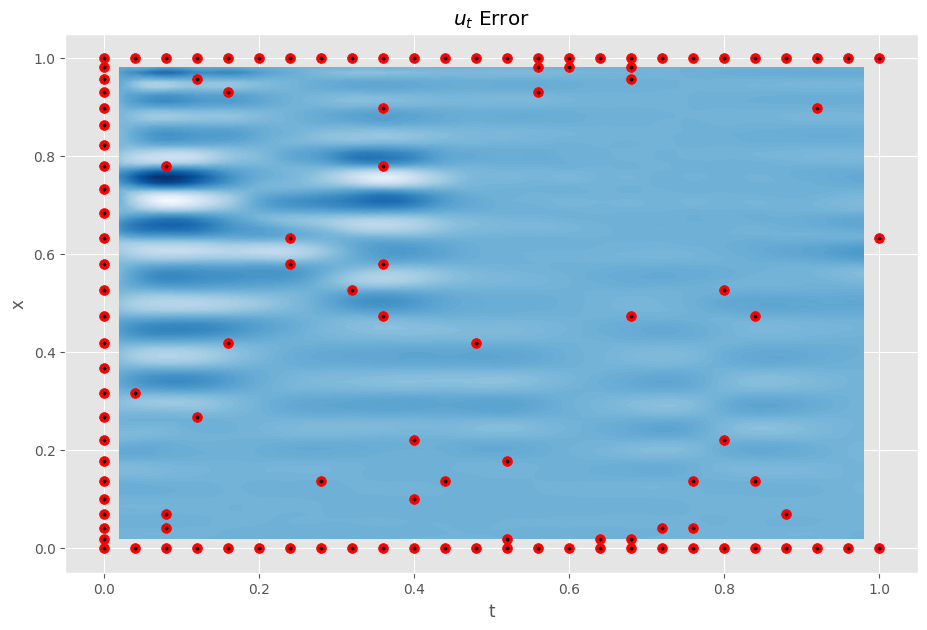

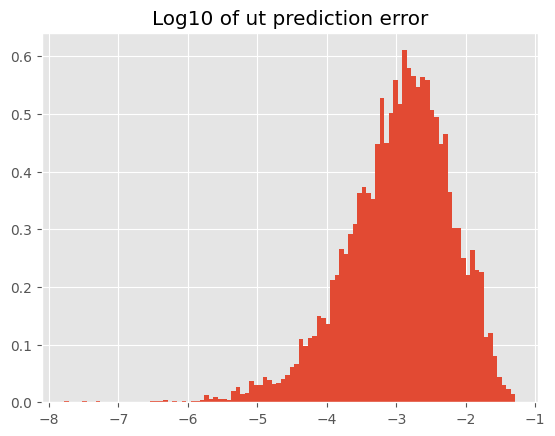

In [29]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()

## Test on a new initial condition

  0%|          | 0/2019 [00:00<?, ?it/s]

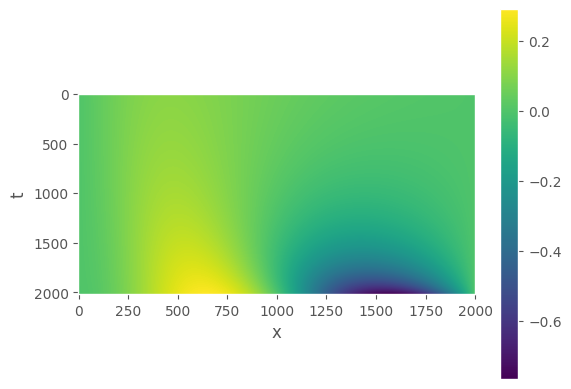

In [75]:
def new_func_u0(x):
    u0 = x * jnp.sin(2*jnp.pi * x)
    return u0
u0_new = new_func_u0(grid)[1:-1]

sols_new,tvals = solver(u0_new,1.01)
sols_new = np.hstack([np.zeros((len(sols_new),1)),sols_new,np.zeros((len(sols_new),1))])

new_interp = RectBivariateSpline(tvals,grid,sols_new)
def new_u_true_function(x):
    return new_interp(x[:,0],x[:,1],grid = False)


plt.imshow(sols_new[::-1],aspect = 0.5)
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.colorbar()

In [76]:
@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol

def example_function(tx):
    return tx[1]
xgrid = jnp.linspace(0,1,100)
tx_example = jnp.vstack([jnp.zeros(100),xgrid]).T
example_features = jnp.hstack([tx_example,jnp.array([jax.vmap(op(example_function,0))(tx_example) for op in feature_operators]).T])

plt.plot(xgrid,get_pred_ut(example_features),label = 'predicted')
plt.plot(xgrid,kappa_func(xgrid)*jax.vmap(dxx_k(example_function,0))(tx_example),label = 'truth')
plt.ylim(-1,1)
plt.legend()

In [118]:
num_grid_x = 36
num_grid_t = 41

tx_int,tx_bdy = build_tx_grid_chebyshev([0,1],[0,1],num_grid_t,num_grid_x)

tx_all = jnp.vstack([tx_int,tx_bdy])

k_u_pde = get_matern(6,0.2)
u_model_pde = CholInducedRKHS(
    tx_all,
    feature_operators,
    k_u_pde
    )


@jit
def get_pred_ut(input_features):
    return P_model.kernel_function(input_features,model_grid_features)@P_sol
tx_init_bdy = jnp.vstack([tx_int[tx_int[:,0]==0],tx_bdy])

new_obs = new_u_true_function(tx_init_bdy)


class PdeModel():
    datafit_weight = 25.
    @jit
    def get_grid_features(u_params):
        evaluation = u_model_pde.evaluate_operators(feature_operators,tx_int,u_params)
        grid_features = evaluation.reshape(len(tx_int),len(feature_operators),order = 'F')
        return jnp.hstack([tx_int,grid_features])
    
    @jit
    def get_grid_target(u_params):
        return u_model_pde.evaluate_operators((dt_k,),tx_int,u_params)
    
    @jit
    def eval_obs_points(u_params):
        return u_model_pde.point_evaluate(tx_init_bdy,u_params)
    
    @jit
    def datafit_residual(u_params):
        obs_preds = PdeModel.eval_obs_points(u_params)
        return new_obs - obs_preds
    
    @jit
    def equation_residual(u_params):
        P_features = PdeModel.get_grid_features(u_params)
        P_model_preds = get_pred_ut(P_features)
        ugrid_target = PdeModel.get_grid_target(u_params)
        return (ugrid_target - P_model_preds)
    
    @jit
    def F(u_params):
        eqn_res = PdeModel.equation_residual(u_params)
        data_res = PdeModel.datafit_residual(u_params)
        return jnp.hstack([
            PdeModel.datafit_weight * data_res/jnp.sqrt(len(data_res)),
            eqn_res/jnp.sqrt(len(eqn_res))
            ])
    
    jac = jit(jacrev(F))

    def loss(u_params):
        return jnp.linalg.norm(PdeModel.F(u_params))**2
    
    @jit
    def damping_matrix(u_params):
        return u_model_pde.get_damping()

In [119]:
new_u_init = jnp.zeros(u_model_pde.num_params)

u_params_pde,loss_vals_pde,JtRes_pde,improvement_ratios_pde,alpha_vals_pde,iterate_history_pde = LevenbergMarquadtMinimize(
    new_u_init.copy(),
    PdeModel,
    beta = 0.,
    max_iter = 501,
    init_alpha=0.001,
    line_search_increase_ratio=1.4,
    print_every = 50
)

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.001693, Jres = 37.27, alpha = 0.0008333, improvement_ratio = 1.0
Iteration 1, loss = 0.000907, Jres = 0.002561, alpha = 0.0006944, improvement_ratio = 1.0
Iteration 2, loss = 0.0006588, Jres = 0.0006263, alpha = 0.0005787, improvement_ratio = 1.0
Iteration 3, loss = 0.0005264, Jres = 0.0003658, alpha = 0.0004823, improvement_ratio = 1.0
Iteration 4, loss = 0.0004409, Jres = 0.0002532, alpha = 0.0004019, improvement_ratio = 1.0
Iteration 5, loss = 0.0003799, Jres = 0.000189, alpha = 0.0003349, improvement_ratio = 1.0
Iteration 50, loss = 4.14e-05, Jres = 6.537e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 100, loss = 3.332e-05, Jres = 2.817e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 150, loss = 3.055e-05, Jres = 2.025e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 2.891e-05, Jres = 1.646e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 250, loss = 2.776e-05, Jres = 1.415e-07, alpha = 8.333e-07, improvement_

In [120]:
u_pde_adj,refinement_losses_pde,reg_vals = adaptive_refine_solution(u_params_pde,PdeModel,alpha_vals_pde[-1],100)

  0%|          | 0/100 [00:00<?, ?it/s]

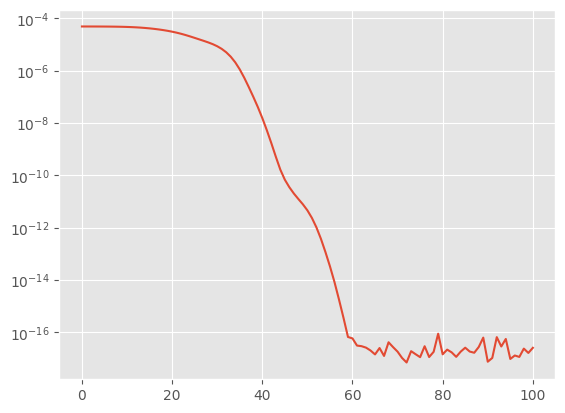

In [121]:
plt.plot(refinement_losses_pde)
plt.yscale('log')

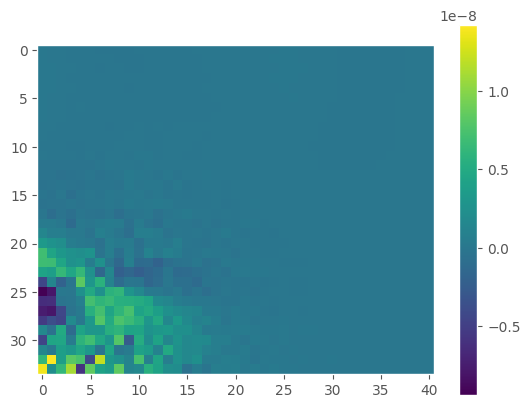

In [122]:
plt.imshow(PdeModel.equation_residual(u_pde_adj).reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()

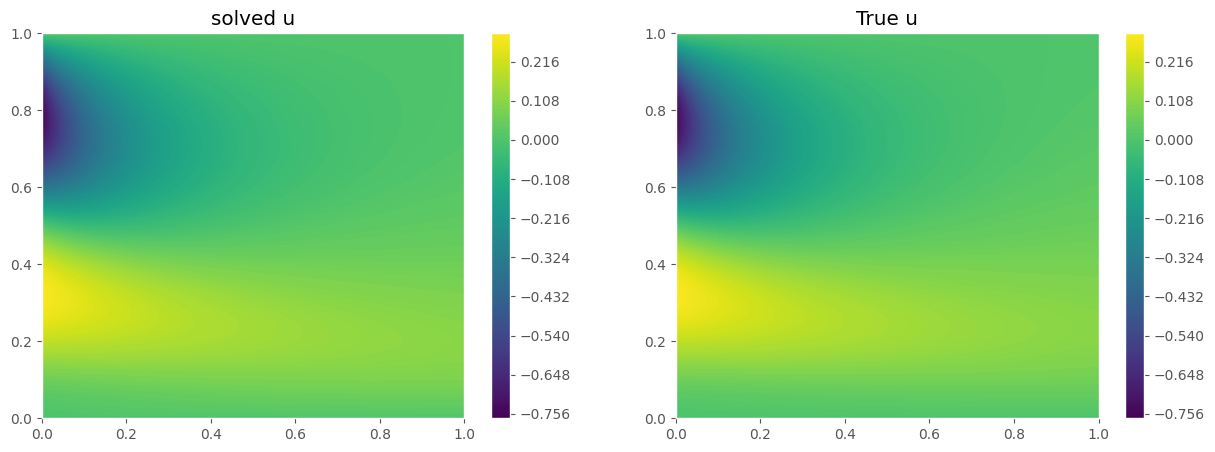

In [123]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T

new_u_eval_fine =u_model_pde.point_evaluate(tx_grid_fine,u_pde_adj)

new_u_true_fine = new_u_true_function(tx_grid_fine)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("solved u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_eval_fine,200)
plt.colorbar()
plt.subplot(1,2,2)
plt.title("True u")
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine,200)
plt.colorbar()


Text(0.5, 1.0, 'Error')

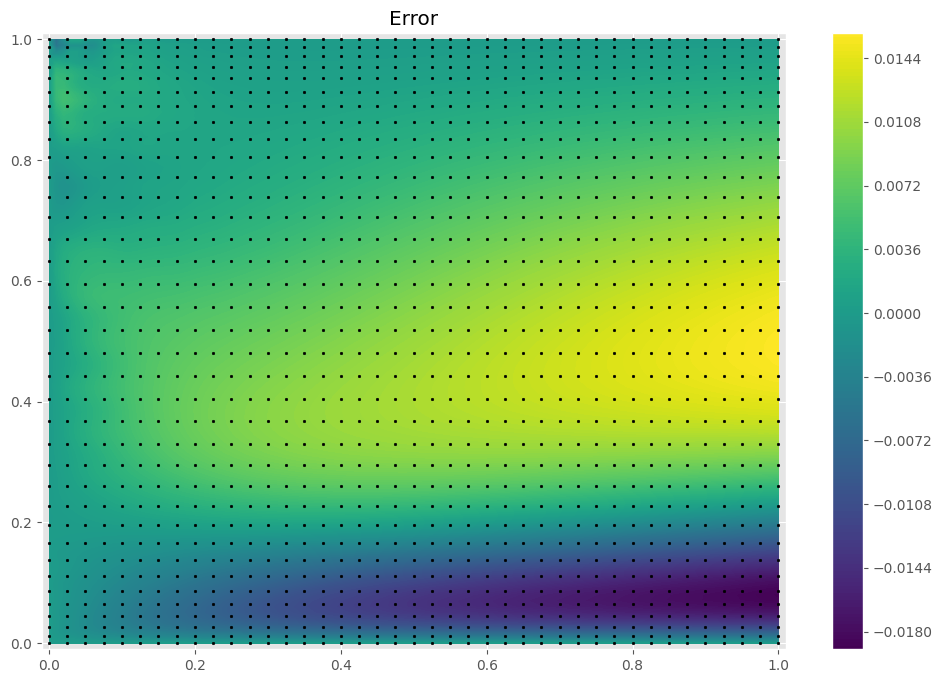

In [124]:
plt.figure(figsize=(12,8))
plt.tricontourf(tx_grid_fine[:,0],tx_grid_fine[:,1],new_u_true_fine-new_u_eval_fine,200)
plt.colorbar()
plt.scatter(tx_all[:,0],tx_all[:,1],s = 3,c='black')
plt.xlim(-0.01,1.01)
plt.ylim(-0.01,1.01)
plt.title("Error")

In [128]:
jnp.max(jnp.abs(new_u_true_fine-new_u_eval_fine))

Array(0.01887475, dtype=float64)

In [130]:
get_nrmse(new_u_true_fine,new_u_eval_fine)

Array(0.05629602, dtype=float64)

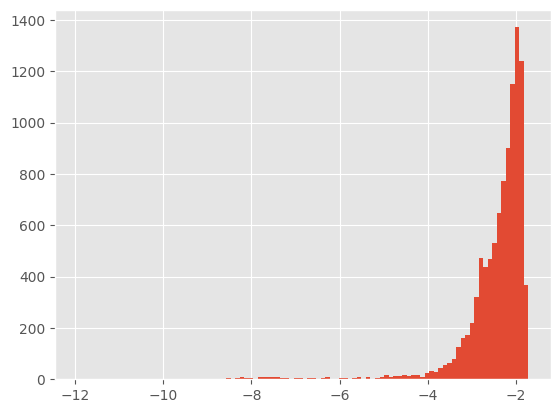

In [131]:
plt.hist(jnp.log10(jnp.abs(new_u_true_fine-new_u_eval_fine) + 1e-12),100)
plt.show()